In [547]:
%reset -f
import gc
gc.collect()

0

In [548]:

import os, sys
import numpy as np
from random import seed, shuffle
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
import cv2
import glob
from torch.utils.data import DataLoader, Dataset
from typing import *
from pathlib import Path
from glob import glob
import tifffile as tiff
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm, Normalize #what the heck is this, so useful
from random import seed, shuffle
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

device is cuda


In [549]:
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
@register_cell_magic
def conditional_run(line, cell):
    if eval(line):
        get_ipython().run_cell(cell)
condition = False

In [550]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath,"minidata")
modelPath = os.path.join(rootPath,"model")
if not os.path.exists(dataPath):
    os.makedirs(dataPath)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)
for dirpath, dirnames, filenames in os.walk(dataPath):
    print(dataPath)
os.listdir(dataPath)

c:\Users\guoyy\OneDrive\Desktop\TESTING\kelp\minidata
c:\Users\guoyy\OneDrive\Desktop\TESTING\kelp\minidata
c:\Users\guoyy\OneDrive\Desktop\TESTING\kelp\minidata
c:\Users\guoyy\OneDrive\Desktop\TESTING\kelp\minidata


['label', 'test', 'train']

In [551]:
train_dir = os.path.join(dataPath, "train")
label_dir = os.path.join(dataPath, "label")
test_dir  = os.path.join(dataPath, "test")

In [552]:
%%conditional_run condition
hhh = glob(train_dir + "/*")
xxx = glob(label_dir + "/*")

with tiff.TiffFile(hhh[1]) as train_temp:
    a = torch.Tensor(train_temp.asarray()[:,:,1]).to(device=device)

with tiff.TiffFile(xxx[1]) as label_temp:
    label = label_temp.asarray()
# plt.imshow(a)
# #it will normalize itself using this plt.imshow(norm = Normalize(vmin=train.min(), vmax=train.max()))
# a.shape

In [553]:
%%conditional_run condition
train_list = []
for i in range(len(hhh)):
    with tiff.TiffFile(hhh[i]) as train_temp:
        train_list.append(torch.Tensor(train_temp.asarray()).to(device=device).unsqueeze(0))
        
a = torch.cat(train_list, dim=0)
a.shape
# a way to combine all the tensor together

In [554]:
%%conditional_run condition
with tiff.TiffFile(hhh[1]) as train_temp:
    a = train_temp.asarray()
plt.imshow(a) # so no plt.imhow() for tiff file

In [555]:
%%conditional_run condition
# Assuming `data` contains values greater than 0
plt.imshow(train, cmap='viridis', norm=Normalize(vmin=train.min(), vmax=train.max()))
plt.colorbar()
plt.show()

In [556]:
class auto_dataset():
    def __init__(self, folder_train : Path, folder_target : Path, split_type = "train", val_size = 0.2) -> None:
        self.fpaths = glob(folder_train + "/*")
        self.tpaths = glob(folder_target + "/*")
        self.length = len(self.fpaths)
        assert len(self.fpaths) == len(self.tpaths), "Mismatch in the number of files between folders"

        seed(42)
        combined = list(zip(self.fpaths, self.tpaths))
        shuffle(combined)
        self.fpaths, self.tpaths = zip(*combined)

        split_index = int(self.length * (1 - val_size))
        
        if split_type not in ["train", "val", "all"]:
            raise ValueError("split_type must be 'train', 'val', or 'all'")
        elif split_type == "train":
            self.fpaths = self.fpaths[:split_index]
            self.tpaths = self.tpaths[:split_index]
        elif split_type == "val":
            self.fpaths = self.fpaths[split_index:]
            self.tpaths = self.tpaths[split_index:]
        # No need for an 'all' condition as it just uses the full lists

        
    def __len__(self) -> int:
        return len(self.fpaths)
    
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        # scaler1 = MinMaxScaler()
        with tiff.TiffFile(self.fpaths[index]) as train_temp:
            train = train_temp.asarray()
            # train = scaler1.fit_transform(train)
            train = (train - train.min())/(train.max() - train.min() + 1e-10)

        # scaler2 = MinMaxScaler()
        with tiff.TiffFile(self.tpaths[index]) as label_temp:
            label = label_temp.asarray()
            # label = scaler2.fit_transform(label)
            label = (label - label.min())/(label.max() - label.min() + 1e-10)
            
        return torch.Tensor(train).permute(2, 0, 1).to(device=device), torch.Tensor(label).to(device=device)

In [557]:
def get_data() -> Tuple[DataLoader, DataLoader]:
    train = auto_dataset(train_dir, label_dir, split_type = "train", val_size = 0.2)
    val = auto_dataset(train_dir, label_dir, split_type = "val", val_size = 0.2)
    train_dl = DataLoader(train, batch_size = 1, shuffle = False)
    val_dl = DataLoader(val, batch_size = 1, shuffle = False)
    return train_dl, val_dl
train_dl, val_dl = get_data()

In [558]:
len(val_dl)

8

In [559]:
%%conditional_run condition
def random_show() -> plt:
    print("this is the worst dataset I have ever seen")
    index = np.random.randint(1,20)
    # index = 8387
    data = auto_dataset(train_dir, label_dir, split_type = "train", val_size = 0.2)
    im, label = data[index]
    print(im.shape)
    # plt.imshow(im.permute(2,1,0).cpu())
random_show()

For the output height \(H_{out}\) and output width \(W_{out}\):

$$
H_{out} = S \cdot (H_{in} - 1) + D \cdot (K - 1) - 2P + O_p + 1
$$

$$
W_{out} = S \cdot (W_{in} - 1) + D \cdot (K - 1) - 2P + O_p + 1
$$

Where:

- $ H_{in} $ and $ W_{in} $ are the height and width of the input volume, respectively.
- \(K\) is the size of the kernel. Assuming a square kernel for simplicity, but this can be expanded to \(K_H\) and \(K_W\) for height and width if they differ.
- \(S\) is the stride of the transposed convolution.
- \(P\) is the amount of padding applied to the input volume on all sides.
- $ O_p $ is the output padding.
- \(D\) is the dilation of the kernel, which increases the effective size of the kernel by inserting zeros between the kernel elements.

In [560]:
len(train_dl)

32

## resnet classifier
****
### we need to figure it out whether the graph has kelp or not, then predict the specific place for the kelp.

In [562]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(7, 16, 3, stride=2, padding=1),  # output: 16 x 175 x 175
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # output: 32 x 88 x 88
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # output: 64 x 44 x 44
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # output: 128 x 22 x 22
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # output: 256 x 11 x 11
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # output: 128 x 22 x 22
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # output: 64 x 44 x 44
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # output: 32 x 88 x 88
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # output: 16 x 175 x 175
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=2, output_padding=1),  # output: 1 x 350 x 350
            nn.Sigmoid()  # Ensure output values are in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
autoencoder = ConvAutoencoder().to(device=device)
for param in autoencoder.parameters():
    param.requires_grad
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

# I need a model outside here
# Training the autoencoder
num_epochs = 4
for epoch in range(num_epochs):
    for ix, data in enumerate(iter(train_dl)):
        x, y = data
        output = autoencoder(x).squeeze(1)
        print(output)
        print(y.shape)
        print(output.shape)
        loss = criterion(output, y)
        print(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed")

tensor([[[0.5631, 0.5132, 0.5668,  ..., 0.5183, 0.5626, 0.5177],
         [0.5348, 0.5340, 0.5365,  ..., 0.5352, 0.5335, 0.5349],
         [0.5593, 0.5175, 0.5690,  ..., 0.5211, 0.5619, 0.5181],
         ...,
         [0.5325, 0.5327, 0.5333,  ..., 0.5319, 0.5329, 0.5330],
         [0.5632, 0.5154, 0.5640,  ..., 0.5168, 0.5637, 0.5181],
         [0.5362, 0.5335, 0.5354,  ..., 0.5341, 0.5342, 0.5333]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
torch.Size([1, 350, 350])
torch.Size([1, 350, 350])
guadafa
0.2890465557575226
tensor([[[0.5630, 0.5130, 0.5668,  ..., 0.5181, 0.5625, 0.5176],
         [0.5346, 0.5338, 0.5363,  ..., 0.5351, 0.5333, 0.5348],
         [0.5592, 0.5174, 0.5689,  ..., 0.5210, 0.5618, 0.5179],
         ...,
         [0.5323, 0.5325, 0.5332,  ..., 0.5318, 0.5328, 0.5328],
         [0.5631, 0.5153, 0.5640,  ..., 0.5167, 0.5637, 0.5180],
         [0.5361, 0.5333, 0.5353,  ..., 0.5340, 0.5341, 0.5332]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
torch

tensor([[[0.5392, 0.4038, 0.5884,  ..., 0.4993, 0.5637, 0.4956],
         [0.5006, 0.4923, 0.4842,  ..., 0.5135, 0.5081, 0.5157],
         [0.4872, 0.4489, 0.6018,  ..., 0.5026, 0.5495, 0.4749],
         ...,
         [0.5151, 0.5262, 0.5322,  ..., 0.5210, 0.5186, 0.5163],
         [0.5453, 0.4816, 0.5634,  ..., 0.5049, 0.5615, 0.4965],
         [0.5288, 0.5271, 0.5145,  ..., 0.5292, 0.5211, 0.5221]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
torch.Size([1, 350, 350])
torch.Size([1, 350, 350])
guadafa
0.2261708527803421
tensor([[[0.5454, 0.4521, 0.5763,  ..., 0.5028, 0.5600, 0.5009],
         [0.5161, 0.5093, 0.5051,  ..., 0.5175, 0.5146, 0.5203],
         [0.5177, 0.4830, 0.5790,  ..., 0.5092, 0.5488, 0.4883],
         ...,
         [0.5221, 0.5262, 0.5267,  ..., 0.5233, 0.5229, 0.5218],
         [0.5480, 0.4969, 0.5602,  ..., 0.5083, 0.5594, 0.5035],
         [0.5308, 0.5286, 0.5246,  ..., 0.5286, 0.5251, 0.5243]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
torch

In [563]:
torch.save(autoencoder.state_dict(), 'autoencoder_state_dict.pth')

In [564]:
torch.save(autoencoder, 'autoencoder_full_model.pth')

## for training

In [565]:
model = torch.load('autoencoder_full_model.pth')

In [566]:
class auto_dataset_test():
    def __init__(self, test_folder : Path) -> None:
        self.fpaths = glob(test_dir + "/*")
                
    def __len__(self) -> int:
        return len(self.fpaths)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor]:
        with tiff.TiffFile(self.fpaths[index]) as test_temp:
            test = test_temp.asarray()
            test = (test - test.min())/(test.max() - test.min() + 1e-10)
            
        return torch.Tensor(test).permute(2, 0, 1).to(device=device)

In [567]:
test = auto_dataset_test(test_dir)
test_dl = DataLoader(test, batch_size=1, shuffle= False)

In [568]:
@torch.no_grad()
def predict(dataloaderrr, listtt):
    model.eval()
    for i, x in enumerate(iter(dataloaderrr)):
        prediction = model(x)
        listtt.append(prediction.squeeze(0).squeeze(0))
    return listtt

In [569]:
temp_list = []
results_list = predict(test_dl, temp_list)

In [570]:
len(results_list)

20

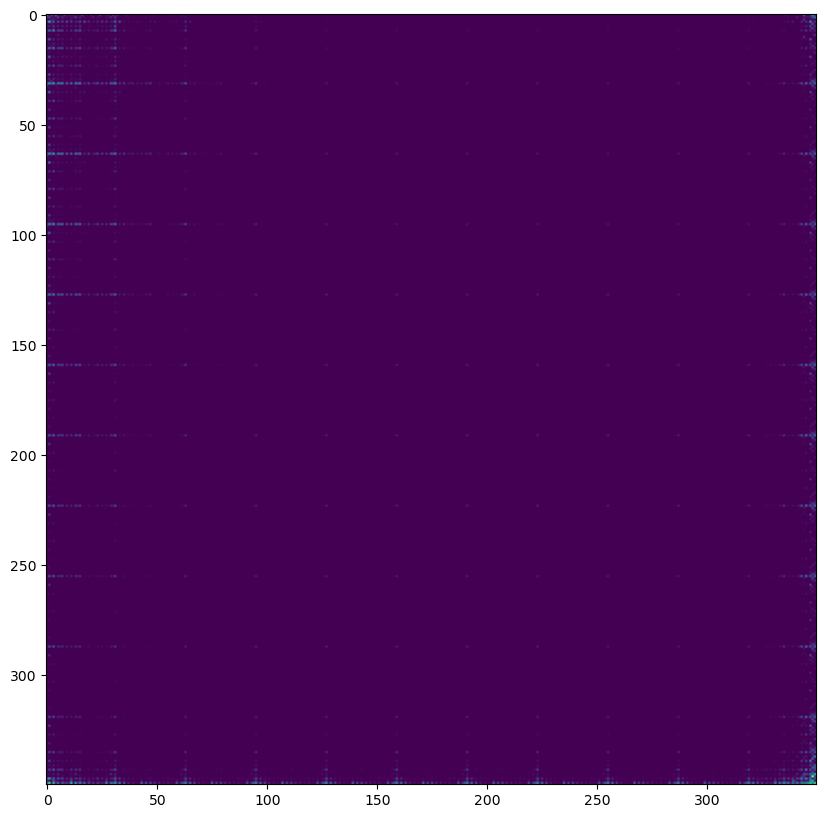

In [571]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(results_list[15].detach().cpu()))

# let's do some optimization

In [ ]:
import torch
import torch.nn as nn

# Assuming pred and target are your tensors with shape [10, 350, 350]
pred = torch.randn(10, 350, 350)  # Example prediction tensor
target = torch.randn(10, 350, 350)  # Example target tensor

# Define MSE loss function
mse_loss_fn = nn.MSELoss()

# Compute the loss
loss = mse_loss_fn(pred, target)

print(f'MSE Loss: {loss.item()}')


MSE Loss: 1.996339201927185


In [ ]:

# Assuming pred and target are your predicted and target tensors respectively
# Both tensors have the shape [1, 350, 350]
pred = torch.randn(1, 350, 350)  # Example predicted tensor
target = torch.randn(1, 350, 350)  # Example target tensor

# Initialize the mean squared error loss function
criterion = nn.MSELoss()

# Calculate the loss
loss = criterion(pred, target)

print("MSE Loss:", loss.item())


MSE Loss: 2.0117647647857666


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming your data is loaded and normalized to [0, 1] range
# For demonstration, we'll create a dummy dataset with the correct shape
# Replace this with your actual data loading code
num_samples = 100  # Number of samples in your dataset
dummy_data = np.random.rand(num_samples, 7, 350, 350).astype(np.float32)  # Dummy data
dummy_targets = np.random.rand(num_samples, 7, 350, 350).astype(np.float32)  # Dummy targets, same as input for autoencoder
dataset = TensorDataset(torch.from_numpy(dummy_data), torch.from_numpy(dummy_targets))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(7, 16, 3, stride=2, padding=1),  # output: 16 x 175 x 175
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # output: 32 x 88 x 88
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # output: 64 x 44 x 44
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # output: 128 x 22 x 22
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # output: 256 x 11 x 11
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # output: 128 x 22 x 22
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # output: 64 x 44 x 44
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # output: 32 x 88 x 88
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # output: 16 x 175 x 175
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 7, 3, stride=2, padding=1, output_padding=1),  # output: 7 x 350 x 350
            nn.Sigmoid()  # Ensure output values are in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
autoencoder = ConvAutoencoder()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

# Training the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data in data_loader:
        imgs, _ = data
        output = autoencoder(imgs)
        loss = criterion(output, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12),
            nn.ReLU(True), 
            nn.Linear(12, 3)  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()  # Output values will be in the range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])  # Normalize to [-1, 1]

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the autoencoder
autoencoder = Autoencoder()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training the autoencoder
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)  # Flatten the images
        output = autoencoder(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed")